In [1]:
%matplotlib inline

import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import multivariate_normal
import os
from dirichlet import simplex
from plot_utils import errorBars

os.chdir('/Users/sbittner/Documents/efn/');

exp_fam = 'dirichlet';

if (exp_fam == 'dirichlet'):
    D = 25;
    flow_id = 'planar30';
    L = 8;
    upl = 100;
    lr_order = -3;
else:
    D = 40;
    flow_id = 'linear1';
    L = 8;
    upl = 160;
    lr_order = -3;


Ks = [1, 10, 100];
Ms = [10, 100, 1000];
num_Ks = len(Ks);
num_Ms = len(Ms);

basedir = '/Users/sbittner/Documents/efn/results/MK/tb/';

N = 500;
fontsize = 20;

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train_R2s = np.zeros((num_Ks, num_Ms, N));
test_R2s = np.zeros((num_Ks, num_Ms, N));
train_KLs = np.zeros((num_Ks, num_Ms, N));
test_KLs = np.zeros((num_Ks, num_Ms, N));

num_etas = np.zeros((num_Ks, num_Ms));
num_nans = np.zeros((num_Ks, num_Ms));

train_R2s_mean = np.zeros((num_Ks, num_Ms));
test_R2s_mean = np.zeros((num_Ks, num_Ms));
train_KLs_mean = np.zeros((num_Ks, num_Ms));
test_KLs_mean = np.zeros((num_Ks, num_Ms));

train_R2s_std = np.zeros((num_Ks, num_Ms));
test_R2s_std = np.zeros((num_Ks, num_Ms));
train_KLs_std = np.zeros((num_Ks, num_Ms));
test_KLs_std = np.zeros((num_Ks, num_Ms));

x = np.log10(np.array(Ms));
legendstrs = [];
for i in range(num_Ks):
    K = Ks[i];
    legendstrs.append('$K_\eta$=%d' % K);
    for j in range(num_Ms):
        M = Ms[j];
        num_models = int(np.round(N / K));
        print(K, M, num_models);
        for rs in range(num_models):
            inds = range(rs*(K), (rs+1)*K);
            modelstr = 'EFN_%s_D=%d_K=%d_M=%d_%s_L=%d_upl=%d_RS=%d/' % \
                        (exp_fam, D, K, M, flow_id, L, upl, rs+1);
            fname = basedir + modelstr + 'results.npz';
            
            if (os.path.isfile(fname)):
                #print('found %s' % fname)
                X = np.load(fname);
                train_R2s_ij = X['train_R2s'];
                train_KLs_ij = X['train_KLs'];
                test_R2s_ij = X['test_R2s'];
                test_KLs_ij = X['test_KLs'];
                
                #check if model finished learning
                num_nans_ij_rs = np.sum(np.isnan(train_R2s_ij[-1,:]));
                if (num_nans_ij_rs):
                    num_nans[i,j] += num_nans_ij_rs;
                    num_etas[i,j] += K;
                elif (np.prod(train_R2s_ij[-1,:] == np.zeros((K,)))):
                    print('%s did not finish learning.' % fname);
                else:
                    train_R2s[i,j,inds] = train_R2s_ij[-1,:];
                    train_KLs[i,j,inds] = train_KLs_ij[-1,:];
                    test_R2s[i,j,inds] = test_R2s_ij[-1,:];
                    test_KLs[i,j,inds] = test_KLs_ij[-1,:];

                    num_etas[i,j] += K;
                
        if (num_etas[i,j] > 0):
            train_R2s_mean[i,j] = np.sum(train_R2s[i,j,:]) / num_etas[i,j];
            train_KLs_mean[i,j] = np.sum(train_KLs[i,j,:]) / num_etas[i,j];
            test_R2s_mean[i,j] = np.sum(test_R2s[i,j,:]) / num_etas[i,j];
            test_KLs_mean[i,j] = np.sum(test_KLs[i,j,:]) / num_etas[i,j];
            train_R2s_std[i,j] = np.sqrt(np.sum(np.square(train_R2s[i,j,:] - train_R2s_mean[i,j])) / num_etas[i,j]);
            train_KLs_std[i,j] = np.sqrt(np.sum(np.square(train_KLs[i,j,:] - train_KLs_mean[i,j])) / num_etas[i,j]);
            test_R2s_std[i,j] = np.sqrt(np.sum(np.square(test_R2s[i,j,:] - test_R2s_mean[i,j])) / num_etas[i,j]);
            test_KLs_std[i,j] = np.sqrt(np.sum(np.square(test_KLs[i,j,:] - test_KLs_mean[i,j])) / num_etas[i,j]);
        else:
            train_R2s_mean[i,j] = -1;
            train_KLs_mean[i,j] = -1;
            test_R2s_mean[i,j] = -1;
            test_KLs_mean[i,j] = -1;

            train_R2s_std[i,j] = 0;
            train_KLs_std[i,j] = 0;
            test_R2s_std[i,j] = 0;
            test_KLs_std[i,j] = 0;
            
print(num_nans);
print(num_etas);

#KLmax = max(np.max(train_KLs_mean), np.max(test_KLs_mean));
#KLbuf = .1;
#R2min = min(np.min(train_R2s_mean), np.min(test_R2s_mean));
#R2buf = .1;

1 10 500
/Users/sbittner/Documents/efn/results/MK/tb/EFN_dirichlet_D=25_K=1_M=10_planar30_L=8_upl=100_RS=129/results.npz did not finish learning.
/Users/sbittner/Documents/efn/results/MK/tb/EFN_dirichlet_D=25_K=1_M=10_planar30_L=8_upl=100_RS=130/results.npz did not finish learning.
/Users/sbittner/Documents/efn/results/MK/tb/EFN_dirichlet_D=25_K=1_M=10_planar30_L=8_upl=100_RS=131/results.npz did not finish learning.
/Users/sbittner/Documents/efn/results/MK/tb/EFN_dirichlet_D=25_K=1_M=10_planar30_L=8_upl=100_RS=132/results.npz did not finish learning.
/Users/sbittner/Documents/efn/results/MK/tb/EFN_dirichlet_D=25_K=1_M=10_planar30_L=8_upl=100_RS=133/results.npz did not finish learning.
/Users/sbittner/Documents/efn/results/MK/tb/EFN_dirichlet_D=25_K=1_M=10_planar30_L=8_upl=100_RS=134/results.npz did not finish learning.
/Users/sbittner/Documents/efn/results/MK/tb/EFN_dirichlet_D=25_K=1_M=10_planar30_L=8_upl=100_RS=135/results.npz did not finish learning.
/Users/sbittner/Documents/efn/re

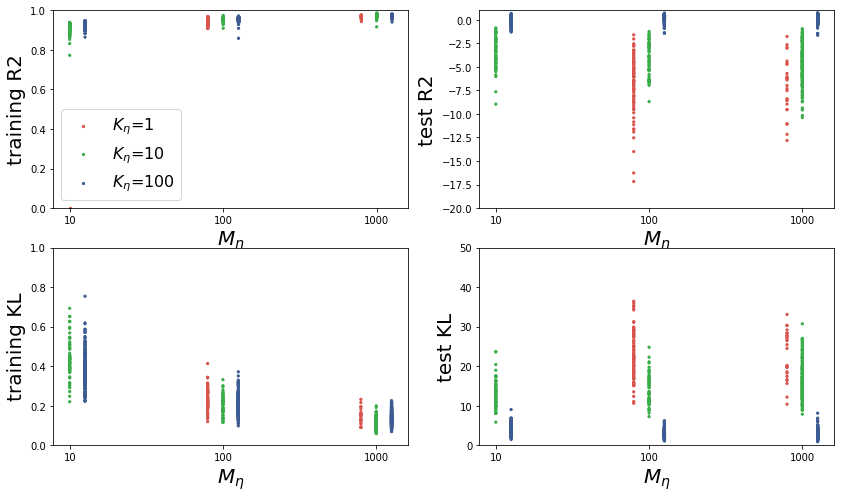

In [4]:
import seaborn as sns
colors = ["pale red", "medium green", "denim blue", "windows blue", "amber", "greyish", "faded green", "dusty purple"];

def categoricalScatter(x, y, legendstrs=[], color_palette=sns.xkcd_palette(colors)):
    fontsize = 16;
    dotsize = 5;
    num_trends = y.shape[0];
    xlen = x.shape[0];
    assert(xlen == y.shape[1]);
    N = y.shape[2];
    
    sizes = dotsize*np.ones((1,));
    # set up legend
    if (len(legendstrs) > 0):
        for i in range(num_trends):
            color = np.tile(np.array([color_palette[i]]), [1, 1]);
            plt.scatter(x[0], y[i,0,0], np.array([dotsize]), c=color);
        plt.legend(legendstrs, fontsize=fontsize);
    xvals = np.zeros((num_trends*xlen*N,));
    yvals = np.zeros((num_trends*xlen*N,));
    colors = np.zeros((num_trends*xlen*N,3));
    sizes = dotsize*np.ones((num_trends*xlen*N,));
    ind = 0;
    for n in range(N):
        for i in range(num_trends):
            for j in range(xlen):
                yval = y[i,j,n];
                if (yval == 0):
                    continue;
                yvals[ind] = yval
                colors[ind,:] = np.array([color_palette[i]]);
                xvals[ind] = x[j] + (i-1)*.1;
                ind += 1;
    plt.scatter(xvals[:ind], yvals[:ind], sizes[:ind], c=colors[:ind]);
    return None;

if (exp_fam == 'dirichlet'):
    R2_train_ylim = 0;
    KL_train_ylim = 1;
    R2_test_ylim = -20;
    KL_test_ylim = 50;
else:
    R2_train_ylim = 0;
    KL_train_ylim = 2;
    R2_test_ylim = -10000;
    KL_test_ylim = 10000;
    

fig = plt.figure(figsize=(14, 8));
ax = fig.add_subplot(2,2,1);
categoricalScatter(x, train_R2s, legendstrs);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('training R2', fontsize=fontsize);
plt.ylim([R2_train_ylim, 1]);

ax = fig.add_subplot(2,2,2);
categoricalScatter(x, test_R2s);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('test R2', fontsize=fontsize);
plt.ylim([R2_test_ylim, 1]);

ax = fig.add_subplot(2,2,3);
categoricalScatter(x, train_KLs, []);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('training KL', fontsize=fontsize);
plt.ylim([0, KL_train_ylim]);

ax = fig.add_subplot(2,2,4);
categoricalScatter(x, test_KLs, []);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('test KL', fontsize=fontsize);
plt.ylim([0, KL_test_ylim]);

plt.show();

print(test_KLs_mean)
print(test_KLs_std)

print(test_R2s_mean)
print(test_R2s_std)

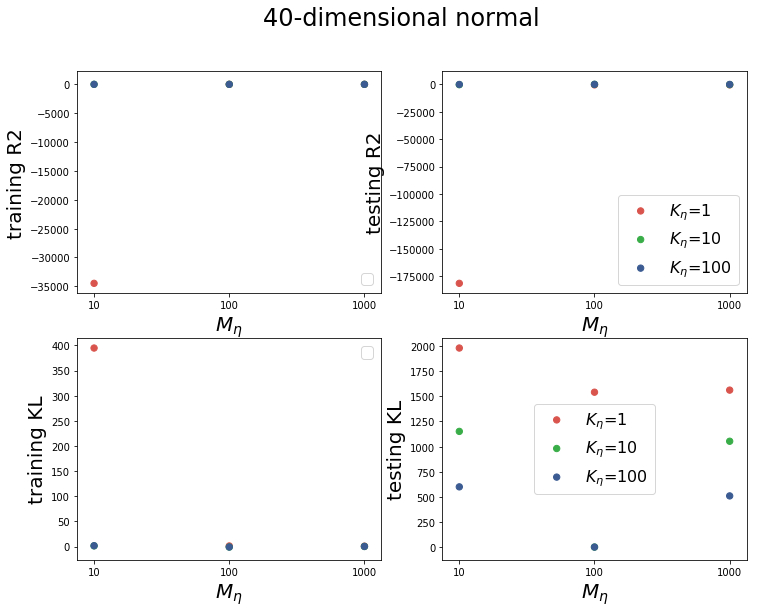

In [9]:
fig = plt.figure(figsize=(12,9));
ax = fig.add_subplot(2,2,1);
errorBars(x, train_R2s_mean, train_R2s_std, []);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('training R2', fontsize=fontsize);
#plt.ylim([0, 1]);

ax = fig.add_subplot(2,2,2);
errorBars(x, test_R2s_mean, test_R2s_std, legendstrs);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('testing R2', fontsize=fontsize);
#plt.ylim([R2min-R2buf, 1]);
plt.suptitle('%d-dimensional %s' % (D, exp_fam), fontsize=fontsize+4);

ax = fig.add_subplot(2,2,3);
errorBars(x, train_KLs_mean, train_KLs_std, []);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('training KL', fontsize=fontsize);
#plt.ylim([0, KLmax+KLbuf]);

ax = fig.add_subplot(2,2,4);
errorBars(x, test_KLs_mean, train_KLs_std, legendstrs);
ax.set_xticks(x);
ax.set_xticklabels(Ms);
plt.xlabel('$M_\eta$', fontsize=fontsize);
plt.ylabel('testing KL', fontsize=fontsize);
#plt.ylim([0, KLmax+KLbuf]);
plt.suptitle('%d-dimensional %s' % (D, exp_fam), fontsize=fontsize+4);
plt.show();

In [10]:
print(num_etas)

[[200. 200.  80.]
 [160.   0. 290.]
 [200.   0. 400.]]
